# Segment, localise and track


Fixing a bug in the code that meant the intracellular mean intensity values weren't accurate due to the downscaling

In [2]:
from macrohet import dataio, tile
from macrohet.notify import send_sms
import numpy as np
from tqdm.auto import tqdm
from cellpose import models
import btrack 
import torch
import os
import dask.array as da
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
# defining cellpose model to use
model = models.Cellpose(
                        gpu=True, 
                        model_type='cyto', 
                        net_avg=True, 
                        device=torch.device('cuda')
                        )

Using device: cuda

NVIDIA RTX A6000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.1 GB


### Define functions to tidy up main block of code

In [3]:
def segment(frame, model = model, channels = [0,0], diameter = 325, min_size = 2500):
    
    masks, flows, styles, diams = model.eval(frame, 
                                             channels = channels, 
                                             diameter = diameter, 
                                             min_size = min_size, 
                                             )
    return masks

# define features to use for tracking 
features = [
  "area",
  "major_axis_length",
  "minor_axis_length",
  "orientation",
  "mean_intensity",
#     "intensity_image"
    ]

scale_factor = 1/5.04

def localise(masks, intensity_image, properties=tuple(features), use_weighted_centroid = False):
    
    # localise objs in images
    objects = btrack.utils.segmentation_to_objects(segmentation=masks,
                                                   intensity_image=intensity_image, 
                                                   properties=properties,
                                                   scale=(scale_factor,scale_factor),
                                                   use_weighted_centroid=use_weighted_centroid, 
                                                   )
                                                   
    return objects

# define config fn to use, using a prob_not_assign = 0.1
config_fn = '/home/dayn/analysis/btrack/models/particle_config_pnassign.json'

def track(objects, masks, config_fn, search_radius = 20):

    # initialise a tracker session using a context manager
    with btrack.BayesianTracker() as tracker:
        # configure the tracker using a config file
        tracker.configure(config_fn)
        # set max search radius
        tracker.max_search_radius = search_radius
        # define tracking method
        tracker.tracking_updates = ["MOTION", "VISUAL"]
        # redefine features so that both channels are included in track measurements
        tracker.features = list(objects[0].properties.keys())
        # append the objects to be tracked
        tracker.append(objects)
        # set the tracking volume
        tracker.volume=((0, masks.shape[-2]*scale_factor), (0, masks.shape[-1]*scale_factor))
        # track them (in interactive mode)
        tracker.track(step_size=25)
        # generate hypotheses and run the global optimizer
        tracker.optimize()
        # store the tracks
        tracks = tracker.tracks

    return tracks

### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [4]:
base_dir = '/mnt/DATA/macrohet/'
# base_dir = '/Volumes/lab-gutierrezm/home/users/dayn/macrohet_nemo/'

In [5]:
metadata_fn = os.path.join(base_dir, 'macrohet_images/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0303K1F1P1R1,Ok,r03c03f01p01-ch1sk1fk1fl1.tiff,3,3,1,1,0,1,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1,0303K1F1P1R2,Ok,r03c03f01p01-ch2sk1fk1fl1.tiff,3,3,1,1,0,2,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
2,0303K1F1P2R1,Ok,r03c03f01p02-ch1sk1fk1fl1.tiff,3,3,1,2,0,1,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3,0303K1F1P2R2,Ok,r03c03f01p02-ch2sk1fk1fl1.tiff,3,3,1,2,0,2,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
4,0303K1F1P3R1,Ok,r03c03f01p03-ch1sk1fk1fl1.tiff,3,3,1,3,0,1,1,...,4E-06,0.135587499,0,2021-04-16T19:09:34.4+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,0609K75F9P1R2,Ok,r06c09f09p01-ch2sk75fk1fl1.tiff,6,9,9,1,74,2,1,...,0,0.135533601,266399.61,2021-04-19T21:14:19.477+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113396,0609K75F9P2R1,Ok,r06c09f09p02-ch1sk75fk1fl1.tiff,6,9,9,2,74,1,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113397,0609K75F9P2R2,Ok,r06c09f09p02-ch2sk75fk1fl1.tiff,6,9,9,2,74,2,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113398,0609K75F9P3R1,Ok,r06c09f09p03-ch1sk75fk1fl1.tiff,6,9,9,3,74,1,1,...,4E-06,0.135537595,266399.61,2021-04-19T21:14:20.037+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [6]:
metadata_path = os.path.join(base_dir, 'macrohet_images/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

# Segment, localise and track

In [7]:
image_dir = os.path.join(base_dir, 'macrohet_images/Images')

In [56]:
tracks_fn = '/mnt/DATA/macrohet/labels/full_localisation/downscaled/(3, 5)_downsc_objs_masks_tracks.h5'#os.path.join(base_dir, f'labels/relocalisation/relocalised_{row,column}.h5')
with btrack.io.HDF5FileHandler(tracks_fn, 'r') as hdf:
#     masks = hdf.segmentation
    old_tracks = hdf.tracks


[INFO][2023/05/05 08:51:38 am] Opening HDF file: /mnt/DATA/macrohet/labels/full_localisation/downscaled/(3, 5)_downsc_objs_masks_tracks.h5...
05-May-23 08:51:38 - btrack.io.hdf - INFO     - Opening HDF file: /mnt/DATA/macrohet/labels/full_localisation/downscaled/(3, 5)_downsc_objs_masks_tracks.h5...
[INFO][2023/05/05 08:51:38 am] Loading tracks/obj_type_1
05-May-23 08:51:38 - btrack.io.hdf - INFO     - Loading tracks/obj_type_1
[INFO][2023/05/05 08:51:38 am] Loading LBEP/obj_type_1
05-May-23 08:51:38 - btrack.io.hdf - INFO     - Loading LBEP/obj_type_1
[INFO][2023/05/05 08:51:38 am] Loading objects/obj_type_1 (26917, 5) (26917 filtered: None)
05-May-23 08:51:38 - btrack.io.hdf - INFO     - Loading objects/obj_type_1 (26917, 5) (26917 filtered: None)
[INFO][2023/05/05 08:51:39 am] Closing HDF file: /mnt/DATA/macrohet/labels/full_localisation/downscaled/(3, 5)_downsc_objs_masks_tracks.h5
05-May-23 08:51:39 - btrack.io.hdf - INFO     - Closing HDF file: /mnt/DATA/macrohet/labels/full_loca

In [105]:
row, column

(6, 9)

In [106]:
with btrack.io.HDF5FileHandler(os.path.join(f'/mnt/DATA/macrohet/labels/relocalisation/infect_label_{3,5}.h5'), 
                                       'r', 
                                       obj_type='obj_type_1'
                                       ) as reader:
        tracks = reader.tracks

[INFO][2023/05/05 09:03:47 am] Opening HDF file: /mnt/DATA/macrohet/labels/relocalisation/infect_label_(3, 5).h5...
05-May-23 09:03:47 - btrack.io.hdf - INFO     - Opening HDF file: /mnt/DATA/macrohet/labels/relocalisation/infect_label_(3, 5).h5...
[INFO][2023/05/05 09:03:47 am] Loading tracks/obj_type_1
05-May-23 09:03:47 - btrack.io.hdf - INFO     - Loading tracks/obj_type_1
[INFO][2023/05/05 09:03:47 am] Loading LBEP/obj_type_1
05-May-23 09:03:47 - btrack.io.hdf - INFO     - Loading LBEP/obj_type_1
[INFO][2023/05/05 09:03:47 am] Loading objects/obj_type_1 (28787, 5) (28787 filtered: None)
05-May-23 09:03:47 - btrack.io.hdf - INFO     - Loading objects/obj_type_1 (28787, 5) (28787 filtered: None)
[INFO][2023/05/05 09:03:48 am] Closing HDF file: /mnt/DATA/macrohet/labels/relocalisation/infect_label_(3, 5).h5
05-May-23 09:03:48 - btrack.io.hdf - INFO     - Closing HDF file: /mnt/DATA/macrohet/labels/relocalisation/infect_label_(3, 5).h5


In [62]:
import seaborn as sns

<AxesSubplot:ylabel='Count'>

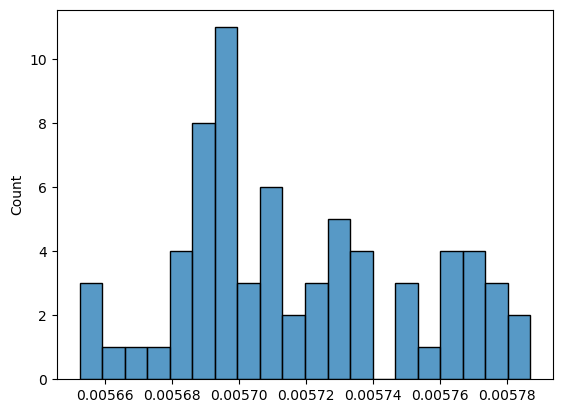

In [64]:
sns.histplot(old_tracks[1].properties['mean_intensity-1'], bins = 20)

In [70]:
import matplotlib.pyplot as plt

In [116]:
from scipy.ndimage.filters import gaussian_filter1d
# y = gaussian_filter1d(sc_df['Intracellular Mtb content'].interpolate().values, 
#                       sigma = 1.5)


/tmp/ipykernel_38850/2843570209.py:1: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


Text(0.5, 1.0, 'Intracellular Mtb of Cell ID 328 (307 in original tracks)')

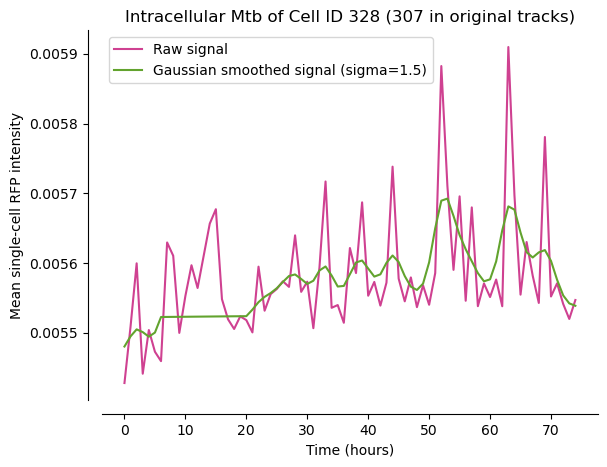

In [125]:
sns.lineplot(data = [track for track in old_tracks if track.ID == 307][0].properties['mean_intensity-1'], color = sns.color_palette('PiYG')[0], label = 'Raw signal')
sns.lineplot(data = gaussian_filter1d([track for track in old_tracks if track.ID == 307][0].properties['mean_intensity-1'], sigma = 1.5), color = sns.color_palette('PiYG')[-1], label = 'Gaussian smoothed signal (sigma=1.5)')
sns.despine(offset=10)
plt.xlabel('Time (hours)')
plt.ylabel('Mean single-cell RFP intensity')
plt.title('Intracellular Mtb of Cell ID 328 (307 in original tracks)')

In [112]:
[track for track in old_tracks if track.ID == 307][0]

,ID,t,x,y,z,parent,root,state,generation,dummy,mean_intensity-0,area,minor_axis_length,mean_intensity-1,orientation,major_axis_length
0,307,0,1008.387268,13.359254,0.000000,307,307,5,0,False,0.007243,643.0,27.950857,0.005428,-1.129078,29.448889
1,307,1,1017.247925,13.459459,0.000000,307,307,5,0,False,0.010503,851.0,28.126667,0.005509,-1.260479,38.840275
2,307,2,1010.211426,21.717817,0.000000,307,307,5,0,False,0.014565,1173.0,28.132944,0.005600,-0.457456,54.936069
3,307,3,1017.624023,17.303713,0.000000,307,307,5,0,False,0.007209,1508.0,41.849625,0.005441,-1.428876,48.023655
4,307,4,1003.279907,23.777607,0.000000,307,307,5,0,False,0.010288,1304.0,26.974810,0.005504,-0.853418,63.027664
5,307,5,1006.153992,21.908966,0.000000,307,307,5,0,False,0.008092,1461.0,30.376835,0.005473,-0.892908,65.788696
6,307,6,1012.292908,16.641914,0.000000,307,307,5,0,False,0.008259,1212.0,30.792671,0.005459,-1.049162,53.504059
7,307,7,1009.447021,17.245659,0.000000,307,307,5,0,False,0.012381,1152.0,29.360464,0.005629,-0.862931,54.527973
8,307,8,996.905212,28.636307,0.000000,307,307,5,0,False,0.011511,1614.0,26.706223,0.005610,-0.758581,81.163391
9,307,9,1004.050476,23.834455,0.000000,307,307,5,0,False,0.010892,1486.0,32.879562,0.005500,-0.731614,63.721680


In [107]:
[track for track in tracks if track.ID == 328][0]

,ID,t,x,y,z,parent,root,state,generation,dummy,mean_intensity,area,minor_axis_length,Infected,orientation,major_axis_length
0,328,0,1008.717163,13.787997,0.000000,328,328,5,0,False,"(3,) array",16539.0,141.621078,0.0,-1.102150,149.536469
1,328,1,1017.692261,13.876625,0.000000,328,328,5,0,False,"(3,) array",21793.0,142.007202,0.0,-1.256759,196.979034
2,328,2,1010.612000,22.133427,0.000000,328,328,5,0,False,"(3,) array",30076.0,142.950394,0.0,-0.462099,276.891296
3,328,3,1017.980957,17.815887,0.000000,328,328,5,0,False,"(3,) array",38735.0,212.037720,0.0,-1.441019,243.356888
4,328,4,1019.862122,18.439526,0.499649,328,328,5,0,True,"(3,) array",NaN,NaN,NaN,NaN,NaN
5,328,5,1006.563110,22.374271,0.000000,328,328,5,0,False,"(3,) array",37566.0,154.405670,0.0,-0.895362,332.633209
6,328,6,1012.670837,17.110456,0.000000,328,328,5,0,False,"(3,) array",31098.0,156.044601,0.0,-1.052552,270.035767
7,328,7,1009.820618,17.756680,0.000000,328,328,5,0,False,"(3,) array",29739.0,149.516876,0.0,-0.867934,276.280579
8,328,8,997.229980,29.168005,0.000000,328,328,5,0,False,"(3,) array",41511.0,135.809814,0.0,-0.761950,409.355835
9,328,9,1004.470764,24.274359,0.000000,328,328,5,0,False,"(3,) array",38268.0,167.457626,0.0,-0.733477,321.869781


Text(0, 0.5, 'Mean single-cell RFP intensity')

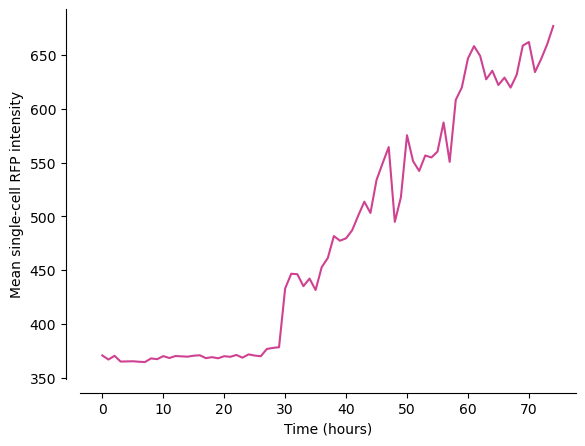

In [108]:
sns.lineplot(data = [track for track in tracks if track.ID == 328][0].properties['mean_intensity'][:,1], color = sns.color_palette('PiYG')[0])
sns.despine(offset=10)
plt.xlabel('Time (hours)')
plt.ylabel('Mean single-cell RFP intensity')

Text(0.5, 1.0, 'Intracellular Mtb of Cell ID 328 (307 in original tracks)')

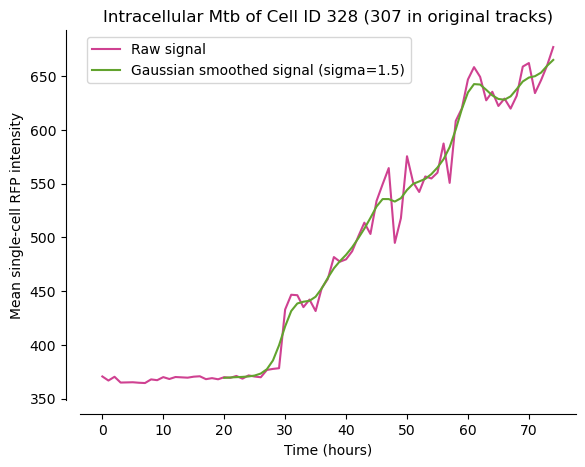

In [124]:
sns.lineplot(data = [track for track in tracks if track.ID == 328][0].properties['mean_intensity'][:,1], color = sns.color_palette('PiYG')[0], label = 'Raw signal')
sns.lineplot(data = gaussian_filter1d([track for track in tracks if track.ID == 328][0].properties['mean_intensity'][:,1], sigma = 1.5), color = sns.color_palette('PiYG')[-1], label = 'Gaussian smoothed signal (sigma=1.5)')
sns.despine(offset=10)
plt.xlabel('Time (hours)')
plt.ylabel('Mean single-cell RFP intensity')
plt.title('Intracellular Mtb of Cell ID 328 (307 in original tracks)')

Text(0.5, 1.0, 'Intracellular Mtb of Cell ID 328 (307 in original tracks)')

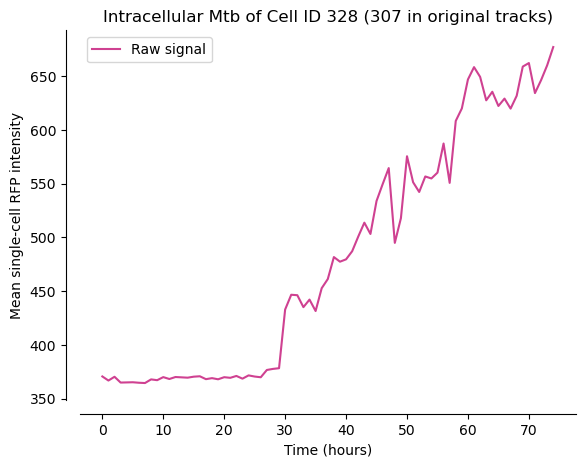

In [130]:
sns.lineplot(data = [track for track in tracks if track.ID == 328][0].properties['mean_intensity'][:,1], color = sns.color_palette('PiYG')[0], label = 'Raw signal')
plt.xlabel('Time (hours)')
sns.despine(offset=10)
plt.ylabel('Mean single-cell RFP intensity')
plt.title('Intracellular Mtb of Cell ID 328 (307 in original tracks)')

Text(0.5, 1.0, 'Intracellular Mtb of Cell ID 328 (307 in original tracks)')

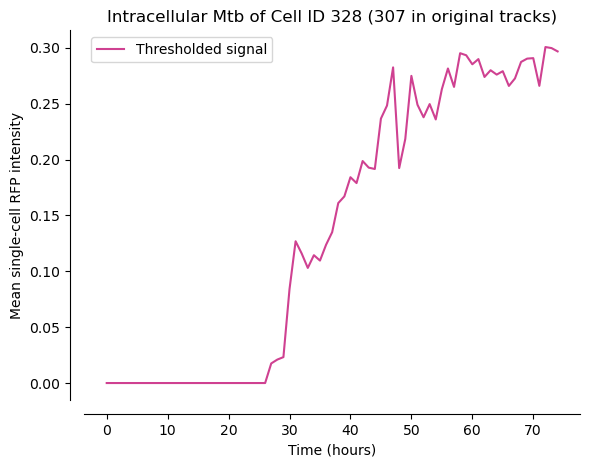

In [131]:
sns.lineplot(data = [track for track in tracks if track.ID == 328][0].properties['mean_intensity'][:,2], color = sns.color_palette('PiYG')[0], label = 'Thresholded signal')
plt.xlabel('Time (hours)')
sns.despine(offset=10)
plt.ylabel('Mean single-cell RFP intensity')
plt.title('Intracellular Mtb of Cell ID 328 (307 in original tracks)')

In [49]:
### iterate over positions
for (row, column), info in tqdm(assay_layout.iterrows(), 
                                desc = 'Progress through positions',
                                total = len(assay_layout)):
    if (row, column) != (3, 4):
        continue
    # tile images
    images = tile.compile_mosaic(image_dir, 
                                 metadata, 
                                 row, 
                                 column, 
                                 set_plane = 'sum_proj',
                                 ).astype(np.uint16)

    # reload seg
    tracks_fn = os.path.join(base_dir, f'labels/full_localisation/{row,column}_objs_masks_tracks.h5')
    with btrack.io.HDF5FileHandler(tracks_fn, 'r') as hdf:
        masks = hdf.segmentation
        
    # get an otsu segmentation of the Mtb channel
#     otsu_mtb = otsu_threshold(images[:,1,...])
    # get a manual thresholding of the mtb channel
    manual_mtb_thresh = images[:,1,...] > 480
    
    # reshape intensity image to be gfp, rfp on last axis for regionprops
    intensity_image = np.stack([images[:,0,...], 
                                images[:,1,...], 
#                                 otsu_mtb, 
                                manual_mtb_thresh], axis = -1)

    # localise objects
    objects = localise(masks, 
                       intensity_image, 
                       )
    
    # filter out small objects
    objects = [o for o in objects if o.properties['area'] > 500]
    
    # add label for infection
    for obj in objects:
        obj.properties = ({"Infected": True} 
                            if obj.properties['mean_intensity'][2] > 0 
                            else {"Infected": False})

    # track on upscaled config fn
    tracks = track(objects, masks, config_fn, search_radius = 20)

    # save out 
    with btrack.io.HDF5FileHandler(os.path.join(base_dir, f'labels/relocalisation/infect_label_{row, column}.h5'), 
                                       'w', 
                                       obj_type='obj_type_1'
                                       ) as writer:
#             writer.write_objects(objects)
            writer.write_tracks(tracks)
            writer.write_segmentation(masks)
    print(f"Checking time indices: {row, column, tracks[0]['t']}")
    send_sms(f"Position {row, column} infect label saved out, {tracks[0]['t']}")

Progress through positions:   0%|          | 0/24 [00:00<?, ?it/s]

[INFO][2023/05/04 02:49:08 pm] Opening HDF file: /mnt/DATA/macrohet/labels/full_localisation/(3, 4)_objs_masks_tracks.h5...
04-May-23 14:49:08 - btrack.io.hdf - INFO     - Opening HDF file: /mnt/DATA/macrohet/labels/full_localisation/(3, 4)_objs_masks_tracks.h5...
[INFO][2023/05/04 02:49:18 pm] Loading segmentation (75, 6048, 6048)
04-May-23 14:49:18 - btrack.io.hdf - INFO     - Loading segmentation (75, 6048, 6048)
[INFO][2023/05/04 02:49:18 pm] Closing HDF file: /mnt/DATA/macrohet/labels/full_localisation/(3, 4)_objs_masks_tracks.h5
04-May-23 14:49:18 - btrack.io.hdf - INFO     - Closing HDF file: /mnt/DATA/macrohet/labels/full_localisation/(3, 4)_objs_masks_tracks.h5
[INFO][2023/05/04 02:49:18 pm] Localizing objects from segmentation...
04-May-23 14:49:18 - btrack.io._localization - INFO     - Localizing objects from segmentation...
100%|█████████████████████████████████████████████████████████████████████| 75/75 [19:15<00:00, 15.41s/it]
[INFO][2023/05/04 03:08:34 pm] Objects are of

GLPK Integer Optimizer 5.0
12536 rows, 10684 columns, 15100 non-zeros
10684 integer variables, all of which are binary
Preprocessing...
6268 rows, 10684 columns, 15100 non-zeros
10684 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 6268
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
6268 rows, 10684 columns, 15100 non-zeros
*     0: obj =   3.217162814e+04 inf =   0.000e+00 (2565)
Perturbing LP to avoid stalling [1239]...
Removing LP perturbation [2568]...
*  2568: obj =   1.648778292e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  2568: mip =     not found yet >=              -inf        (1; 0)
+  2568: >>>>>   1.648778292e+04 >=   1.648778292e+04   0.0% (1; 0)
+  2568: mip =   1.648778292e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMA

[INFO][2023/05/04 03:08:52 pm] Ending BayesianTracker session
04-May-23 15:08:52 - btrack.core - INFO     - Ending BayesianTracker session
[INFO][2023/05/04 03:08:52 pm] Opening HDF file: /mnt/DATA/macrohet/labels/relocalisation/infect_label_(3, 4).h5...
04-May-23 15:08:52 - btrack.io.hdf - INFO     - Opening HDF file: /mnt/DATA/macrohet/labels/relocalisation/infect_label_(3, 4).h5...
[INFO][2023/05/04 03:08:53 pm] Writing objects/obj_type_1
04-May-23 15:08:53 - btrack.io.hdf - INFO     - Writing objects/obj_type_1
[INFO][2023/05/04 03:08:53 pm] Writing labels/obj_type_1
04-May-23 15:08:53 - btrack.io.hdf - INFO     - Writing labels/obj_type_1
[INFO][2023/05/04 03:08:53 pm] Loading objects/obj_type_1 (26904, 5) (26904 filtered: None)
04-May-23 15:08:53 - btrack.io.hdf - INFO     - Loading objects/obj_type_1 (26904, 5) (26904 filtered: None)
[INFO][2023/05/04 03:08:54 pm] Writing properties/obj_type_1/area (26904,)
04-May-23 15:08:54 - btrack.io.hdf - INFO     - Writing properties/obj_t

Checking time indices: (3, 4, [0, 1, 2])


In [33]:
import napari

In [34]:
v = napari.Viewer()

/home/dayn/analysis/btrack/btrack/dataio.py:3: UserWarning: `btrack.dataio` has been deprecated. Please use `btrack.io` subpackage instead.
  warnings.warn(  # noqa: B028


Assistant skips harvesting pyclesperanto as it's not installed.


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


In [36]:
v.add_labels(masks[0])

<Labels layer 'Labels' at 0x7f632b23a580>

In [35]:
v.add_image(manual_mtb_thresh[0])

<Image layer 'Image' at 0x7f633525ac40>

In [37]:
v.add_image(manual_mtb_thresh[0]*(masks[0] == 125))

<Image layer 'Image [1]' at 0x7f635c7d86a0>

In [48]:
np.mean((manual_mtb_thresh[0]*(masks[0] == 125))).compute().compute()

0.0001380053050026595

In [41]:
np.sum((masks[0] == 125))

14889

In [42]:
np.sum(manual_mtb_thresh[0]*(masks[0] == 125)).compute().compute()

5048

In [46]:
5048/14889

0.3390422459533884

In [32]:
manual_mtb_thresh[0]

dask.array<getitem, shape=(6048, 6048), dtype=bool, chunksize=(2016, 2016), chunktype=numpy.ndarray>

In [9]:
row, column = 3, 5

In [10]:
images = tile.compile_mosaic(image_dir, 
                                 metadata, 
                                 row, 
                                 column, 
                                 set_plane = 'sum_proj',
                                 ).astype(np.uint16)

# reload seg
tracks_fn = os.path.join(base_dir, f'labels/full_localisation/{row,column}_objs_masks_tracks.h5')
with btrack.io.HDF5FileHandler(tracks_fn, 'r') as hdf:
    masks = hdf.segmentation

# reshape intensity image to be gfp, rfp on last axis for regionprops
intensity_image = np.stack([images[:,0,...], 
                            images[:,1,...]], axis = -1)

[INFO][2023/05/03 06:14:24 PM] Opening HDF file: /mnt/DATA/macrohet/labels/full_localisation/(3, 5)_objs_masks_tracks.h5...
[INFO][2023/05/03 06:14:34 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/05/03 06:14:34 PM] Closing HDF file: /mnt/DATA/macrohet/labels/full_localisation/(3, 5)_objs_masks_tracks.h5


In [11]:
objects = localise(masks[0:2], 
                       intensity_image[0:2], 
                       )

[INFO][2023/05/03 06:14:54 PM] Localizing objects from segmentation...
100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:24<00:00, 12.33s/it]
[INFO][2023/05/03 06:15:18 PM] Objects are of type: <class 'dict'>
[INFO][2023/05/03 06:15:18 PM] ...Found 1080 objects in 2 frames.


# Adding Mtb threshold to objects

In [13]:
# features_to_add = {"my_feature": 0.1}

obj = objects[0]
# obj.properties = features_to_add

In [17]:
obj.properties['mean_intensity'][1] > 0

True

In [25]:
for obj in objects:
    obj.properties = ({"Infected": True} 
                        if obj.properties['mean_intensity'][1] > 0 
                        else {"Infected": False})

In [26]:
objects[0]

,ID,x,y,z,t,dummy,states,label,area,major_axis_length,minor_axis_length,orientation,mean_intensity,Infected
0,0,71.709602,16.420708,0.0,0,False,7,5,21045,214.41384,129.839618,0.75574,"(2,) array",True


In [13]:
import napari

In [15]:
# v = napari.Viewer()
v.add_image(objects[0].properties['intensity_image'], channel_axis=-1, colormap=['green', 'magenta'])

[<Image layer 'Image' at 0x7faa90e00f70>,
 <Image layer 'Image [1]' at 0x7faa99138ca0>]

In [16]:
rfp_glimpse = objects[0].properties['intensity_image'][...,-1]

In [22]:
for obj in objects:
    v.add_image(obj.properties['intensity_image'], channel_axis=-1, colormap=['green', 'magenta'], name = obj.ID)
    if obj.ID == 10:
        break

### obj 0 and obj 1 are negative and positive respectively

In [26]:
objects[0].properties['mean_intensity'][-1]

array([1194.51385127,  344.16593015])

In [27]:
objects[1].properties['mean_intensity'][-1]

array([1148.94431453,  361.85228883])

In [35]:
len(objs)

536

# Apply a thresholding

In [38]:
rfp_t0 = images[0,1]

In [79]:
images.shape

(75, 2, 6048, 6048)

In [80]:
images[:,1,...]

dask.array<getitem, shape=(75, 6048, 6048), dtype=uint16, chunksize=(1, 2016, 2016), chunktype=numpy.ndarray>

In [84]:
otsu_threshold(images[0:2,1,0:100,0:100])

TypeError: '>=' not supported between instances of 'str' and 'int'

In [75]:
import skimage.filters as filters

def otsu_threshold_segmentation(image):
    """
    Applies Otsu's thresholding segmentation to a grayscale image.

    Parameters:
    -----------
    image : ndarray
        A grayscale image.

    Returns:
    --------
    ndarray
        A binary image with the same shape as the input image.
    """
    # Compute Otsu's threshold value
    thresh = filters.threshold_otsu(image)

    # Apply binary thresholding using the threshold value
    binary_image = image > thresh

    return binary_image


In [83]:
import numpy as np
from skimage.filters import threshold_otsu

def otsu_threshold(images):
    """
    Computes Otsu's threshold value and returns a binary segmentation for
    each image in a time series of grayscale images.

    Parameters:
    -----------
    images : ndarray
        A 3D array of shape (n_images, height, width) containing a time series
        of grayscale images.

    Returns:
    --------
    ndarray
        A boolean array of shape (n_images, height, width) containing the
        binary segmentation for each image in the time series.
    """
    segmentations = np.zeros(images.shape, dtype=bool)
    for i, image in enumerate(images):
        threshold = threshold_otsu(image)
        segmentations[i] = image > threshold
    return segmentations


In [47]:
image = rfp_t0.compute().compute()

In [49]:
image.shape

(6048, 6048)

In [67]:
help(filters.threshold_otsu)

Help on function threshold_otsu in module skimage.filters.thresholding:

threshold_otsu(image=None, nbins=256, *, hist=None)
    Return threshold value based on Otsu's method.
    
    Either image or hist must be provided. If hist is provided, the actual
    histogram of the image is ignored.
    
    Parameters
    ----------
    image : (N, M[, ..., P]) ndarray, optional
        Grayscale input image.
    nbins : int, optional
        Number of bins used to calculate histogram. This value is ignored for
        integer arrays.
    hist : array, or 2-tuple of arrays, optional
        Histogram from which to determine the threshold, and optionally a
        corresponding array of bin center intensities. If no hist provided,
        this function will compute it from the image.
    
    
    Returns
    -------
    threshold : float
        Upper threshold value. All pixels with an intensity higher than
        this value are assumed to be foreground.
    
    References
    ----------

In [50]:
# image = rfp_t0[0:100, 0:100]

# Compute Otsu's threshold value
thresh = filters.threshold_otsu(image)
print(thresh)
# Apply binary thresholding using the threshold value
binary_image = image > thresh

1260


In [51]:
v.add_image(binary_image)

<Image layer 'binary_image' at 0x7fa99d690190>

In [52]:
v.add_image(rfp_t0)

<Image layer 'rfp_t0' at 0x7fa97e773be0>

In [56]:
v.add_image(rfp_t0>480)

<Image layer 'Image [1]' at 0x7fa976db3eb0>

# Apply otsu and basic thresholding to glimpse - cannot do

In [70]:
v.add_image(rfp_glimpse)

<Image layer 'rfp_glimpse' at 0x7fa9917aaaf0>

In [71]:
image = rfp_glimpse

In [72]:
thresh = filters.threshold_otsu(image)
print(thresh)
# Apply binary thresholding using the threshold value
binary_image = image > thresh

0


In [74]:
v.add_image(image>480)

<Image layer 'Image' at 0x7fa9688c6700>

# Apply image wide

In [ ]:
%%time
otsu_threshold(images[0:2,1,...])

In [87]:
# get an otsu segmentation of the Mtb channel
otsu_mtb = otsu_threshold(images[:,1,...])
# get a manual thresholding of the mtb channel
manual_mtb_thresh = images[:,1,...] > 480

# reshape intensity image to be gfp, rfp on last axis for regionprops
intensity_image = np.stack([images[:,0,...], 
                            images[:,1,...], 
                            otsu_mtb, 
                            manual_mtb_thresh], axis = -1)

# localise objects
objects = localise(masks[0:2], 
                   intensity_image[0:2], 
                   )


KeyboardInterrupt

